In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean, col, lit, expr, count
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.sql.functions import when
from pyspark.ml.classification import DecisionTreeClassifier, LogisticRegression, RandomForestClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np

In [2]:
spark = SparkSession.builder.appName("BankLoanApproval").getOrCreate()

In [3]:
data_path = "/content/Loan-Approval-Prediction.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)
df.show(5)

+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
| Loan_ID|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|LP001002|  Male|     No|         0|    Graduate|           No|           5849|              0.0|      NULL|             360|             1|        Urban|          Y|
|LP001003|  Male|    Yes|         1|    Graduate|           No|           4583|           1508.0|       128|             360|             1|        Rural|          N|
|LP001005|  Male|    Yes|         0|    Graduate|          Yes|           3000|              0.0|        66|             360|             1|        Urban|          Y

In [4]:
df = df.drop("Loan_ID")

In [ ]:
# Handle Missing Values
# categorical values with mode
mode_gender = df.groupBy("Gender").count().orderBy(col("count").desc()).first()["Gender"]
df = df.fillna({"Gender": mode_gender})

mode_married = df.groupBy("Married").count().orderBy(col("count").desc()).first()["Married"]
df = df.fillna({"Married": mode_married})

mode_dependents = df.groupBy("Dependents").count().orderBy(col("count").desc()).first()["Dependents"]
df = df.fillna({"Dependents": mode_dependents})

mode_self_employed = df.groupBy("Self_Employed").count().orderBy(col("count").desc()).first()["Self_Employed"]
df = df.fillna({"Self_Employed": mode_self_employed})

mode_credit_history = df.groupBy("Credit_History").count().orderBy(col("count").desc()).first()["Credit_History"]
df = df.fillna({"Credit_History": mode_credit_history})

mode_loan_amount_term = df.groupBy("Loan_Amount_Term").count().orderBy(col("count").desc()).first()["Loan_Amount_Term"]
df = df.fillna({"Loan_Amount_Term": mode_loan_amount_term})

# numerical values with mean
mean_loan_amount = df.select(mean(col("LoanAmount"))).collect()[0][0]
df = df.fillna({"LoanAmount": mean_loan_amount})
df.show(5)


+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|  Male|     No|         0|    Graduate|           No|           5849|              0.0|       146|             360|             1|        Urban|          Y|
|  Male|    Yes|         1|    Graduate|           No|           4583|           1508.0|       128|             360|             1|        Rural|          N|
|  Male|    Yes|         0|    Graduate|          Yes|           3000|              0.0|        66|             360|             1|        Urban|          Y|
|  Male|    Yes|         0|Not Graduate|           N

In [6]:
#Encode Categorical Variables
categorical_features = ["Gender", "Married", "Dependents", "Education", "Self_Employed", "Property_Area"]
indexers = [StringIndexer(inputCol=feature, outputCol=f"{feature}_Index") for feature in categorical_features]
encoders = [OneHotEncoder(inputCol=f"{feature}_Index", outputCol=f"{feature}_Encoded") for feature in categorical_features]
encoding_pipeline = Pipeline(stages=indexers + encoders)
df = encoding_pipeline.fit(df).transform(df)
df.select([f"{feature}_Encoded" for feature in categorical_features]).show(5)  # Print encoded features


+--------------+---------------+------------------+-----------------+---------------------+---------------------+
|Gender_Encoded|Married_Encoded|Dependents_Encoded|Education_Encoded|Self_Employed_Encoded|Property_Area_Encoded|
+--------------+---------------+------------------+-----------------+---------------------+---------------------+
| (1,[0],[1.0])|      (1,[],[])|     (3,[0],[1.0])|    (1,[0],[1.0])|        (1,[0],[1.0])|        (2,[1],[1.0])|
| (1,[0],[1.0])|  (1,[0],[1.0])|     (3,[1],[1.0])|    (1,[0],[1.0])|        (1,[0],[1.0])|            (2,[],[])|
| (1,[0],[1.0])|  (1,[0],[1.0])|     (3,[0],[1.0])|    (1,[0],[1.0])|            (1,[],[])|        (2,[1],[1.0])|
| (1,[0],[1.0])|  (1,[0],[1.0])|     (3,[0],[1.0])|        (1,[],[])|        (1,[0],[1.0])|        (2,[1],[1.0])|
| (1,[0],[1.0])|      (1,[],[])|     (3,[0],[1.0])|    (1,[0],[1.0])|        (1,[0],[1.0])|        (2,[1],[1.0])|
+--------------+---------------+------------------+-----------------+-------------------

In [7]:
# Feature Scaling
numerical_features = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term", "Credit_History"]
assembler = VectorAssembler(inputCols=numerical_features, outputCol="Numerical_Features")
assembled_df = assembler.transform(df)

scaler = StandardScaler(inputCol="Numerical_Features", outputCol="Scaled_Features")
scaler_model = scaler.fit(assembled_df)
scaled_df = scaler_model.transform(assembled_df)
scaled_df.select("Scaled_Features").show(5)

+--------------------+
|     Scaled_Features|
+--------------------+
|[0.95743331159124...|
|[0.75019949855063...|
|[0.49107538635215...|
|[0.42281590764920...|
|[0.98215077270430...|
+--------------------+
only showing top 5 rows



In [8]:
scaled_df = scaled_df.withColumn("Total_Income", col("ApplicantIncome") + col("CoapplicantIncome"))
scaled_df = scaled_df.withColumn("Income_to_Loan_Ratio", col("Total_Income") / col("LoanAmount"))
scaled_df.select("Total_Income", "Income_to_Loan_Ratio").show(5)  # Print engineered features


+------------+--------------------+
|Total_Income|Income_to_Loan_Ratio|
+------------+--------------------+
|      5849.0|   40.06164383561644|
|      6091.0|          47.5859375|
|      3000.0|   45.45454545454545|
|      4941.0|              41.175|
|      6000.0|    42.5531914893617|
+------------+--------------------+
only showing top 5 rows



In [9]:
scaled_df = scaled_df.withColumn("Loan_Status_Binary", when(col("Loan_Status") == "Y", 1).otherwise(0))
assembler = VectorAssembler(inputCols=[
    "Scaled_Features", "Gender_Encoded", "Married_Encoded", "Dependents_Encoded", "Education_Encoded",
    "Self_Employed_Encoded", "Property_Area_Encoded"
], outputCol="Final_Features")
final_data = assembler.transform(scaled_df)
final_data.select("Final_Features").show(5)

+--------------------+
|      Final_Features|
+--------------------+
|[0.95743331159124...|
|[0.75019949855063...|
|[0.49107538635215...|
|[0.42281590764920...|
|[0.98215077270430...|
+--------------------+
only showing top 5 rows



In [10]:
df.show(5)

+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+------------+-------------+----------------+---------------+-------------------+-------------------+--------------+---------------+------------------+-----------------+---------------------+---------------------+
|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|Gender_Index|Married_Index|Dependents_Index|Education_Index|Self_Employed_Index|Property_Area_Index|Gender_Encoded|Married_Encoded|Dependents_Encoded|Education_Encoded|Self_Employed_Encoded|Property_Area_Encoded|
+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+------------+-------------+----------------+---------------+-------------------+-------------------+---

In [11]:
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)
print(f"Training Data Count: {train_data.count()}, Testing Data Count: {test_data.count()}")

Training Data Count: 517, Testing Data Count: 97


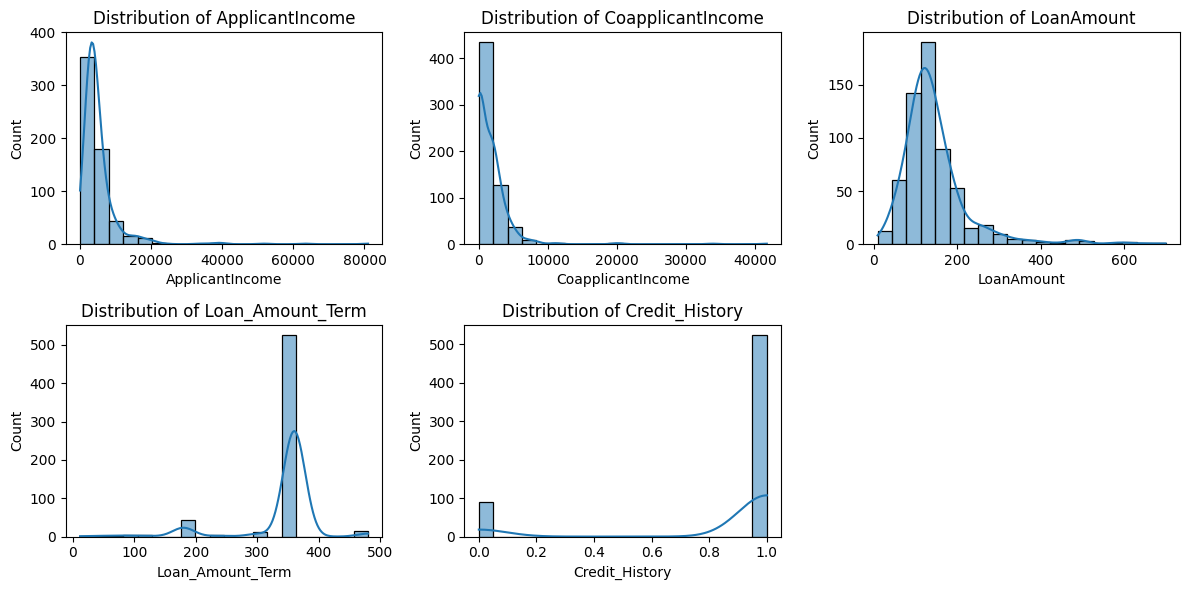

In [12]:
# EDA
numerical_df = scaled_df.select(numerical_features).toPandas()
plt.figure(figsize=(12, 6))
for i, column in enumerate(numerical_features):
    plt.subplot(2, 3, i+1)
    sns.histplot(numerical_df[column], kde=True, bins=20)
    plt.title(f"Distribution of {column}")
plt.tight_layout()
plt.show()

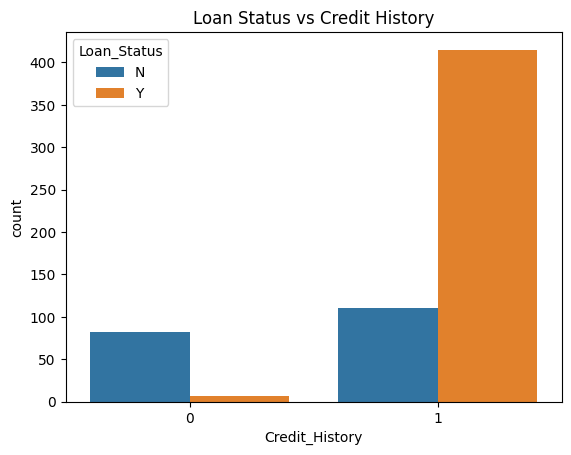

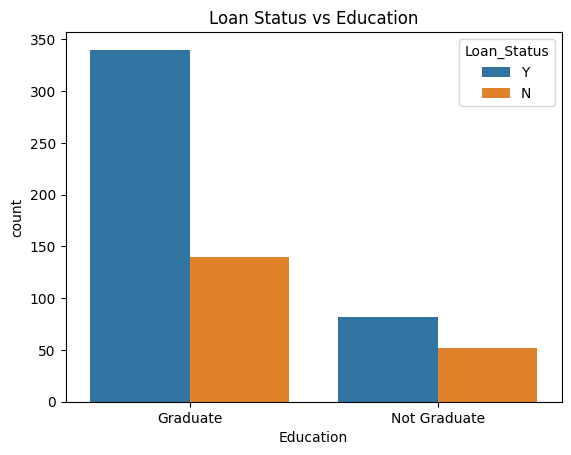

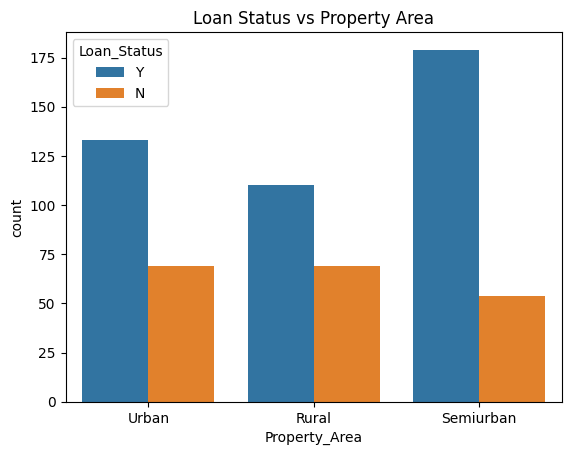

In [14]:
loan_status_df = df.select("Loan_Status", "Credit_History", "Education", "Property_Area").toPandas()
sns.countplot(data=loan_status_df, x="Credit_History", hue="Loan_Status")
plt.title("Loan Status vs Credit History")
plt.show()

sns.countplot(data=loan_status_df, x="Education", hue="Loan_Status")
plt.title("Loan Status vs Education")
plt.show()

sns.countplot(data=loan_status_df, x="Property_Area", hue="Loan_Status")
plt.title("Loan Status vs Property Area")
plt.show()

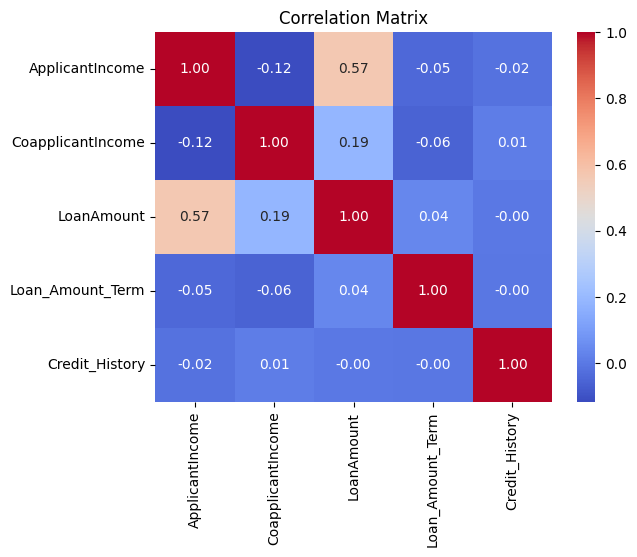

In [15]:
correlation_matrix = numerical_df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

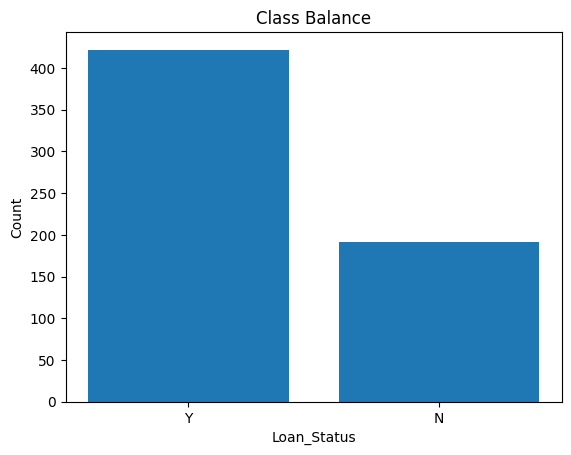

In [16]:
class_balance = df.groupBy("Loan_Status").count().toPandas()

plt.bar(class_balance["Loan_Status"], class_balance["count"])
plt.title("Class Balance")
plt.xlabel("Loan_Status")
plt.ylabel("Count")
plt.show()

In [18]:
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np

train_data_pandas = train_data.select("Final_Features", "Loan_Status_Binary").toPandas()
X = np.array([np.array(Vectors.dense(row["Final_Features"])) for _, row in train_data_pandas.iterrows()])
y = train_data_pandas["Loan_Status_Binary"].values

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

resampled_df = pd.DataFrame({"Final_Features": list(X_resampled), "Loan_Status_Binary": y_resampled})
resampled_df["Final_Features"] = resampled_df["Final_Features"].apply(lambda x: Vectors.dense(x))
resampled_spark_df = spark.createDataFrame(resampled_df)

print(f"Count of X_resampled: {X_resampled.shape[0]}")
print(f"Count of y_resampled: {len(y_resampled)}")
print(f"Data after SMOTE: {resampled_spark_df.count()} rows")


Count of X_resampled: 708
Count of y_resampled: 708
Data after SMOTE: 708 rows


In [21]:
resampled_class_distribution = resampled_spark_df.groupBy("Loan_Status_Binary").count()
print("Resampled Training Data Class Distribution (After SMOTE):")
resampled_class_distribution.show()
print(f"Data after SMOTE: {resampled_spark_df.count()} rows")

Resampled Training Data Class Distribution (After SMOTE):
+------------------+-----+
|Loan_Status_Binary|count|
+------------------+-----+
|                 0|  354|
|                 1|  354|
+------------------+-----+

Data after SMOTE: 708 rows


Model Training

DecisionTree

In [22]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

dt = DecisionTreeClassifier(labelCol="Loan_Status_Binary", featuresCol="Final_Features")

paramGrid_dt = (
    ParamGridBuilder()
    .addGrid(dt.maxDepth, [5, 10, 15, 20])
    .addGrid(dt.minInstancesPerNode, [1, 2, 5])
    .addGrid(dt.impurity, ["gini", "entropy"])
    .build()
)

evaluator_dt = MulticlassClassificationEvaluator(
    labelCol="Loan_Status_Binary",
    predictionCol="prediction",
    metricName="accuracy"
)

crossval_dt = CrossValidator(
    estimator=dt,
    estimatorParamMaps=paramGrid_dt,
    evaluator=evaluator_dt,
    numFolds=5
)

cvModel_dt = crossval_dt.fit(train_data)

best_model_dt = cvModel_dt.bestModel
print(f"Best max depth: {best_model_dt.getMaxDepth()}")
print(f"Best min instances per node: {best_model_dt.getMinInstancesPerNode()}")
print(f"Best impurity criterion: {best_model_dt.getImpurity()}")

test_results_dt = best_model_dt.transform(test_data)

accuracy_dt = evaluator_dt.evaluate(test_results_dt)
print(f"Decision Tree Accuracy on Test Data: {accuracy_dt:.4f}")

y_true_dt = test_results_dt.select("Loan_Status_Binary").toPandas().values.flatten()
y_pred_dt = test_results_dt.select("prediction").toPandas().values.flatten()

print("\nClassification Report:\n", classification_report(y_true_dt, y_pred_dt))
print("\nConfusion Matrix:\n", confusion_matrix(y_true_dt, y_pred_dt))

feature_importances = best_model_dt.featureImportances.toArray()
feature_names = ["Feature_" + str(i) for i in range(len(feature_importances))]
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

print("\nFeature Importances:\n", importance_df)


Best max depth: 20
Best min instances per node: 1
Best impurity criterion: entropy
Decision Tree Accuracy on Test Data: 0.8000

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.80      0.83        75
           1       0.73      0.80      0.76        50

    accuracy                           0.80       125
   macro avg       0.79      0.80      0.79       125
weighted avg       0.81      0.80      0.80       125


Confusion Matrix:
 [[60 15]
 [10 40]]

Feature Importances:
        Feature  Importance
4    Feature_4    0.209807
2    Feature_2    0.186148
0    Feature_0    0.164979
1    Feature_1    0.119380
12  Feature_12    0.075310
3    Feature_3    0.045476
10  Feature_10    0.041553
13  Feature_13    0.039968
6    Feature_6    0.034631
8    Feature_8    0.026131
5    Feature_5    0.021409
9    Feature_9    0.019760
7    Feature_7    0.012511
11  Feature_11    0.002936


Logistic Regression

In [23]:
lr = LogisticRegression(featuresCol="Final_Features", labelCol="Loan_Status_Binary")
lr_model = lr.fit(resampled_spark_df)
lr_predictions = lr_model.transform(test_data)
lr_predictions.select("prediction", "Loan_Status_Binary").show(5)

y_true_lr = lr_predictions.select("Loan_Status_Binary").toPandas().values.flatten()  # True labels
y_pred_lr = lr_predictions.select("prediction").toPandas().values.flatten()  # Predicted labels

print("Classification Report:\n", classification_report(y_true_lr, y_pred_lr))
print("\nConfusion Matrix:\n", confusion_matrix(y_true_lr, y_pred_lr))

+----------+------------------+
|prediction|Loan_Status_Binary|
+----------+------------------+
|       0.0|                 1|
|       1.0|                 0|
|       0.0|                 0|
|       1.0|                 1|
|       0.0|                 0|
+----------+------------------+
only showing top 5 rows

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.60      0.70        75
           1       0.58      0.84      0.69        50

    accuracy                           0.70       125
   macro avg       0.72      0.72      0.70       125
weighted avg       0.74      0.70      0.70       125


Confusion Matrix:
 [[45 30]
 [ 8 42]]


SVM

In [47]:
svm = LinearSVC(labelCol="Loan_Status_Binary", featuresCol="Final_Features")

paramGrid_svm = ParamGridBuilder() \
    .addGrid(svm.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(svm.maxIter, [50, 100, 200]) \
    .build()

evaluator_svm = BinaryClassificationEvaluator(labelCol="Loan_Status_Binary")

crossval_svm = CrossValidator(estimator=svm,
                               estimatorParamMaps=paramGrid_svm,
                               evaluator=evaluator_svm,
                               numFolds=3)

cvModel_svm = crossval_svm.fit(train_data)

best_model_svm = cvModel_svm.bestModel
print("Best SVM model parameters:")
print(f"Regularization parameter (C): {best_model_svm._java_obj.getRegParam()}")
print(f"Max iterations: {best_model_svm._java_obj.getMaxIter()}")

test_results_svm = best_model_svm.transform(test_data)
accuracy_svm = evaluator_svm.evaluate(test_results_svm)
print(f"Best SVM model test accuracy: {accuracy_svm:.2f}")


Best SVM model parameters:
Regularization parameter (C): 1.0
Max iterations: 100
Best SVM model test accuracy: 0.75


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_results_svm.select("Loan_Status_Binary").toPandas()["Loan_Status_Binary"]
y_pred = test_results_svm.select("prediction").toPandas()["prediction"]

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Rejected", "Approved"]))

conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)




Classification Report:
              precision    recall  f1-score   support

    Rejected       1.00      0.37      0.54        75
    Approved       0.52      1.00      0.68        50

    accuracy                           0.62       125
   macro avg       0.76      0.69      0.61       125
weighted avg       0.81      0.62      0.60       125


Confusion Matrix:
[[28 47]
 [ 0 50]]


RandomForestClassifier

In [20]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

rf = RandomForestClassifier(labelCol="Loan_Status_Binary", featuresCol="Final_Features")

paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

evaluator_rf = MulticlassClassificationEvaluator(labelCol="Loan_Status_Binary", metricName="accuracy")

crossval_rf = CrossValidator(estimator=rf,
                             estimatorParamMaps=paramGrid_rf,
                             evaluator=evaluator_rf,
                             numFolds=3)

cvModel_rf = crossval_rf.fit(train_data)

best_model_rf = cvModel_rf.bestModel
print(f"Best number of trees: {best_model_rf.getNumTrees}")
print(f"Best max depth: {best_model_rf.getMaxDepth()}")

test_results_rf = best_model_rf.transform(test_data)

accuracy_rf = evaluator_rf.evaluate(test_results_rf)
print(f"Random Forest accuracy: {accuracy_rf:.2f}")

y_true_rf = test_results_rf.select("Loan_Status_Binary").toPandas().values.flatten()
y_pred_rf = test_results_rf.select("prediction").toPandas().values.flatten()

from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:\n", classification_report(y_true_rf, y_pred_rf))

print("Confusion Matrix:\n", confusion_matrix(y_true_rf, y_pred_rf))

import pandas as pd
feature_importances = best_model_rf.featureImportances.toArray()
feature_names = ["Feature_" + str(i) for i in range(len(feature_importances))]
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

print("Feature Importances:\n", importance_df)

Best number of trees: 50
Best max depth: 10
Random Forest accuracy: 0.83
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.81      0.85        75
           1       0.75      0.86      0.80        50

    accuracy                           0.83       125
   macro avg       0.83      0.84      0.83       125
weighted avg       0.84      0.83      0.83       125

Confusion Matrix:
 [[61 14]
 [ 7 43]]
Feature Importances:
        Feature  Importance
4    Feature_4    0.264325
0    Feature_0    0.149027
2    Feature_2    0.127474
1    Feature_1    0.093661
12  Feature_12    0.089227
6    Feature_6    0.041635
10  Feature_10    0.040446
3    Feature_3    0.039759
13  Feature_13    0.035139
5    Feature_5    0.028124
7    Feature_7    0.025625
11  Feature_11    0.024396
8    Feature_8    0.024070
9    Feature_9    0.017092


KNN

In [25]:
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType, IntegerType
import numpy as np

train_data_list = train_data.select("Final_Features", "Loan_Status_Binary").collect()
train_data_broadcast = spark.sparkContext.broadcast(train_data_list)

def euclidean_distance(test_point, train_point):
    test_vec = np.array(test_point)
    train_vec = np.array(train_point)
    return float(np.sqrt(np.sum((test_vec - train_vec) ** 2)))

def knn_predict(test_point, k):
    distances = []
    for train_row in train_data_broadcast.value:
        train_point, label = train_row["Final_Features"], train_row["Loan_Status_Binary"]
        dist = euclidean_distance(test_point, train_point)
        distances.append((dist, label))
    k_nearest = sorted(distances, key=lambda x: x[0])[:k]
    labels = [label for _, label in k_nearest]
    return int(max(set(labels), key=labels.count))

knn_udf = F.udf(lambda x: knn_predict(x, k= 5), IntegerType())

test_data_with_knn = test_data.withColumn("knn_prediction", knn_udf(F.col("Final_Features")))

y_true_knn = test_data_with_knn.select("Loan_Status_Binary").toPandas().values.flatten()
y_pred_knn = test_data_with_knn.select("knn_prediction").toPandas().values.flatten()

from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:\n", classification_report(y_true_knn, y_pred_knn))
print("Confusion Matrix:\n", confusion_matrix(y_true_knn, y_pred_knn))


Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.69      0.74        75
           1       0.62      0.74      0.67        50

    accuracy                           0.71       125
   macro avg       0.71      0.72      0.71       125
weighted avg       0.73      0.71      0.71       125

Confusion Matrix:
 [[52 23]
 [13 37]]


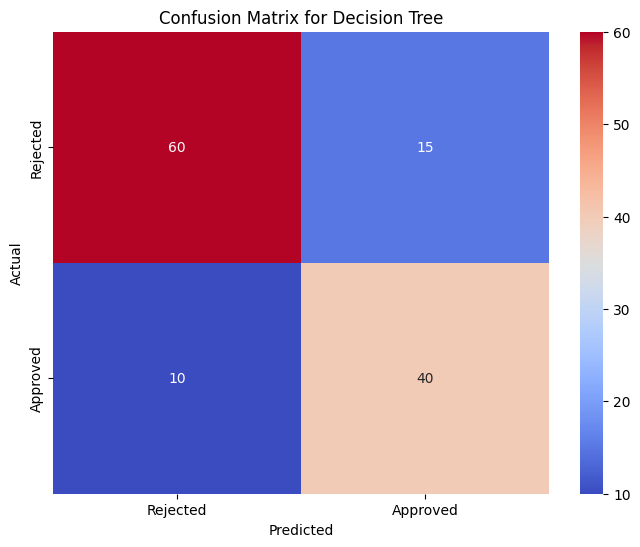

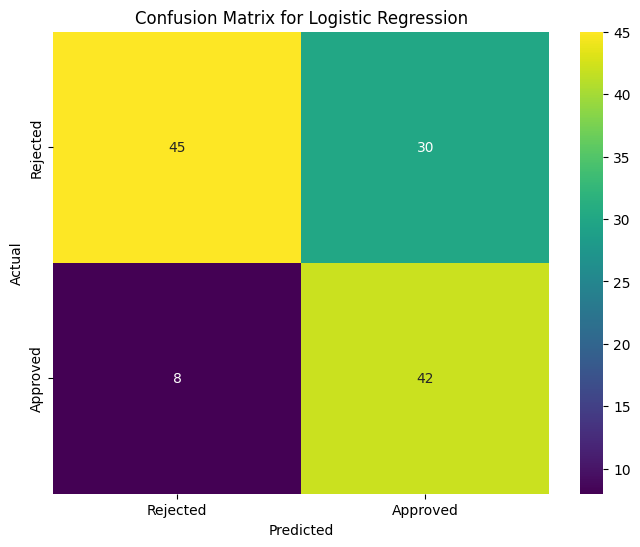

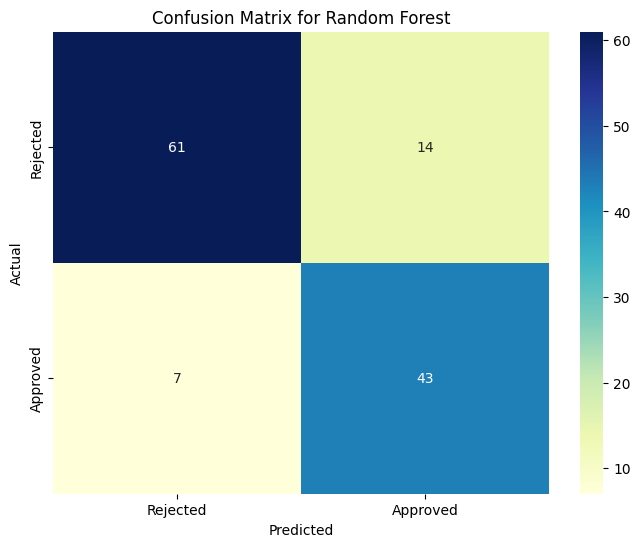

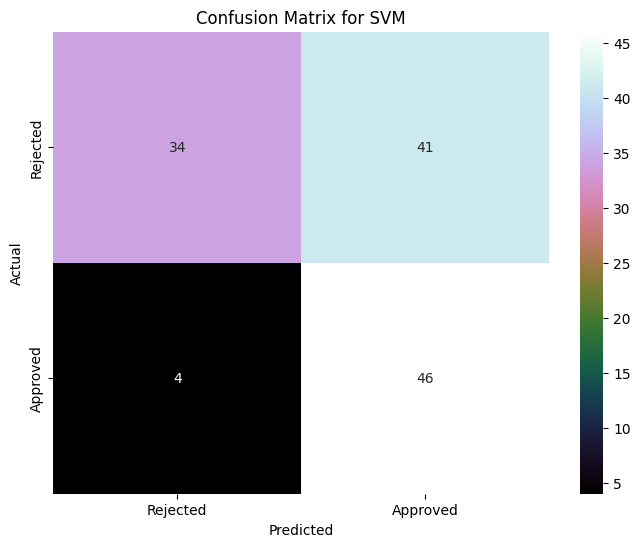

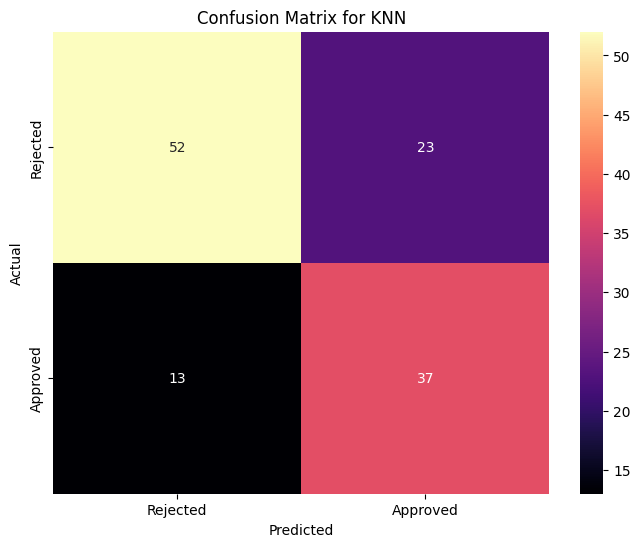

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, model_name, cmap="coolwarm"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=["Rejected", "Approved"], yticklabels=["Rejected", "Approved"])
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion_matrix(y_true_dt, y_pred_dt, "Decision Tree", cmap="coolwarm")

plot_confusion_matrix(y_true_lr, y_pred_lr, "Logistic Regression", cmap="viridis")

plot_confusion_matrix(y_true_rf, y_pred_rf, "Random Forest", cmap="YlGnBu")

plot_confusion_matrix(y_true_svm, y_pred_svm, "SVM", cmap="cubehelix")

plot_confusion_matrix(y_true_knn, y_pred_knn, "KNN", cmap="magma")


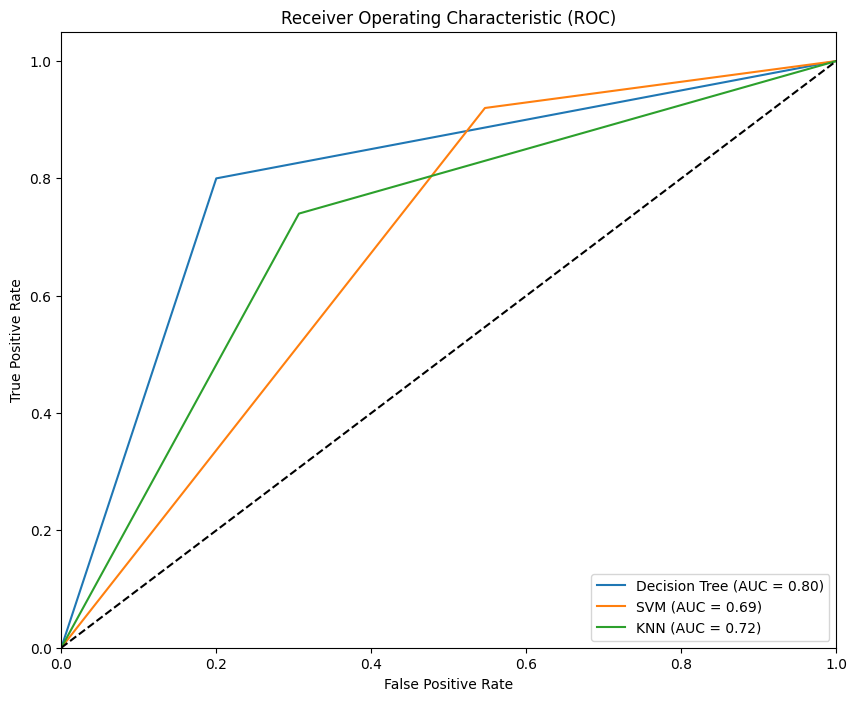

In [ ]:
def plot_roc_curve(y_true, y_pred, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.figure(figsize=(10, 8))
plot_roc_curve(y_true_dt, y_pred_dt, "Decision Tree")
plot_roc_curve(y_true_svm, y_pred_svm, "SVM")
plot_roc_curve(y_true_knn, y_pred_knn, "KNN")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


<ipython-input-36-6868ff8ea91d>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], "k--", color="gray")


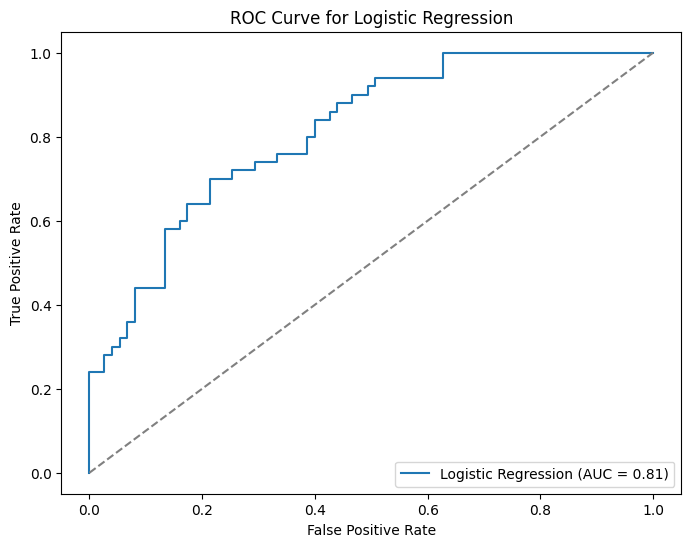

<ipython-input-36-6868ff8ea91d>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], "k--", color="gray")


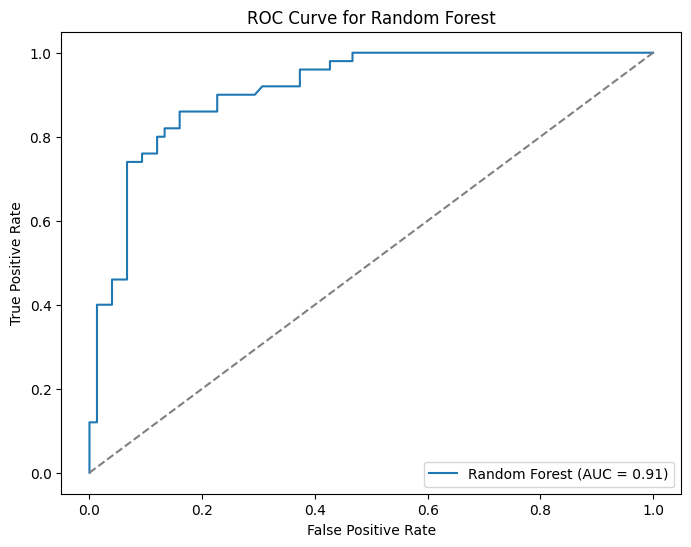

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, probabilities, model_name):
    fpr, tpr, _ = roc_curve(y_true, probabilities)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], "k--", color="gray")
    plt.title(f"ROC Curve for {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

probabilities_lr = lr_predictions.select("probability").rdd.map(lambda x: x[0][1]).collect()  # Extract positive class probabilities
plot_roc_curve(y_true_lr, probabilities_lr, "Logistic Regression")

probabilities_rf = test_results_rf.select("probability").rdd.map(lambda x: x[0][1]).collect()
plot_roc_curve(y_true_rf, probabilities_rf, "Random Forest")


In [40]:
svm = LinearSVC(labelCol="Loan_Status_Binary", featuresCol="Final_Features")

paramGrid_svm = ParamGridBuilder() \
    .addGrid(svm.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(svm.maxIter, [50, 100, 200]) \
    .build()

evaluator_svm = BinaryClassificationEvaluator(labelCol="Loan_Status_Binary")

crossval_svm = CrossValidator(estimator=svm,
                               estimatorParamMaps=paramGrid_svm,
                               evaluator=evaluator_svm,
                               numFolds=3)

cvModel_svm = crossval_svm.fit(train_data)

best_model_svm = cvModel_svm.bestModel
print("Best SVM model parameters:")
print(f"Regularization parameter (C): {best_model_svm._java_obj.getRegParam()}")
print(f"Max iterations: {best_model_svm._java_obj.getMaxIter()}")

test_results_svm = best_model_svm.transform(test_data)
accuracy_svm = evaluator_svm.evaluate(test_results_svm)
print(f"Best SVM model test accuracy: {accuracy_svm:.2f}")


Best SVM model test accuracy: 0.75


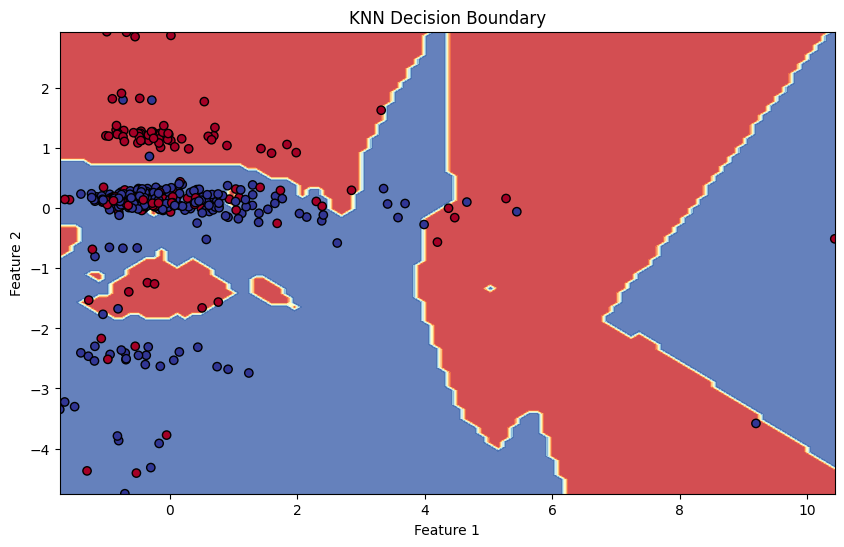

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_2d, y_train)

Z_knn = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z_knn = Z_knn.reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z_knn, alpha=0.8, cmap=plt.cm.RdYlBu)
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, edgecolors='k', marker='o', cmap=plt.cm.RdYlBu)
plt.title('KNN Decision Boundary')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


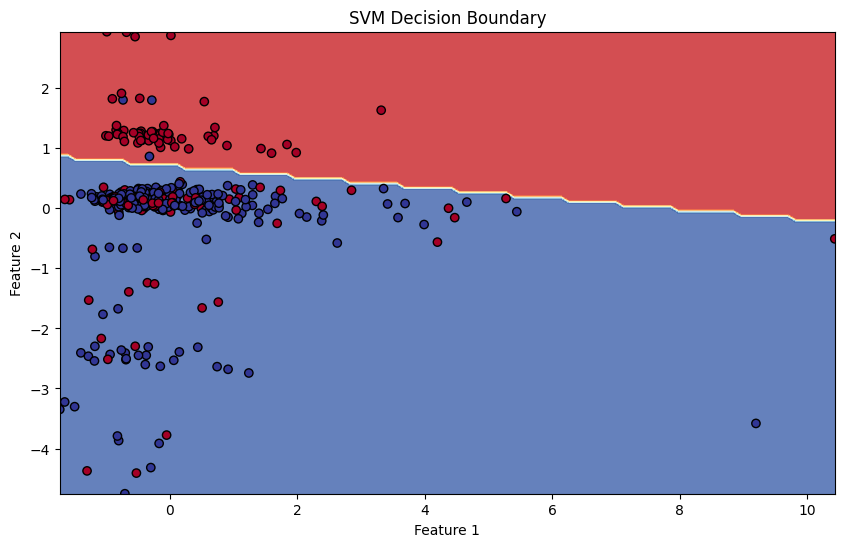

In [ ]:
from sklearn.svm import SVC  
svm = SVC(C=1.0, kernel="linear")  
svm.fit(X_train_2d, y_train)

xx, yy = np.meshgrid(np.linspace(X_train_2d[:, 0].min(), X_train_2d[:, 0].max(), 100),
                     np.linspace(X_train_2d[:, 1].min(), X_train_2d[:, 1].max(), 100))

Z_svm = svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z_svm = Z_svm.reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z_svm, alpha=0.8, cmap=plt.cm.RdYlBu)
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, edgecolors='k', marker='o', cmap=plt.cm.RdYlBu)
plt.title('SVM Decision Boundary')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()
